# Movie Box Office revenue predictor


## Authors: Christopher Budd, Mustafa Syed, and Jayant Varma 

### Objective: 
To predict the revenue generated by a movie given its other features such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, etc.



**Dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing** Kindly download the dataset on your local machine and run it accordingly (see how we ran it under 'Loading the dataset')

# Movies daily updated dataset description:

**Attributes for the dataset:**
The below attributes are copied **AS IS** from the original dataset website https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data 

1. id	--> TMDB id

2. title	--> Title of the movie

3. genres	--> Genres are separated by'-'

4. original_language	--> The language the movie was made in

5. overview	    --> short description of movie

6. popularity   --> TMDB metric, in depth description can be found here, https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/discussion/400671 

7. production_companies	--> '-' separated production company

8. release_date     --> movie release date

9. budget	--> budget of the movie

10. revenue	    --> Revenue generated by the movie

11. runtime	    --> duration of the movie

12. status	--> status (Released, or planned, or other)

13. tagline	    --> tagline

14. vote_average	--> average of votes given by tmdb users

15. vote_count	       --> vote counts

16. credits	        --> '-' separated cast if movie

17. keywords	    --> '-' separated keywords that desciption of movie

18. poster_path	    --> poster image

19. backdrop_path	--> background images

20. recommendations --> '-' separated recommended movie id


**Missing values:** There exist missing values in multiple features of the above dataset as we'll soon see


**Duplicated values:** 
There exist duplicated values in multiple features of the above dataset as we'll soon see


# 1: Looking at the big picture, framing the problem, and business practicality

### Frame the problem
1. Supervised learning – training examples are labeled.
2. A regression task – predict a value (Revenue).
3. Batch learning 
    - Small data set
    - No continuous flow of data coming into the system
    - No need to adjust to changing data rapidly

### Big Picture/Business objective:
At the end of the day every business wants to know how much revenue they can generate given the all production inputs. Our project solves this problem for the movie industry. See objective below.

### Objective: 
To predict the revenue generated by a movie given its other featuers such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, and recommendations.


# Initial set up

In [239]:
# Import libraries

import sklearn
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [240]:
movies = pd.read_csv(".\movies.csv") 
# Please note: The file is massive, and not be referred online. You MUST download the file on your local machine from https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=drive_link (MAKE SURE YOU ONLY USE YOUR YORK UNIVERSITY GOOGLE ACCOUNT!!!)

# 2 First impressions on the dataset, graphs of the EDA, and patterns found


Note: We use only the dataset from January 1st 2015 until Nov. 5th 2023

In [241]:
# Convert 'release_date' to datetime format
movies['release_date'] = pd.to_datetime(movies['release_date'])

# Create a mask for filtering dates
mask = (movies['release_date'] >= '2015-01-01') & (movies['release_date'] <= '2023-11-05')

# Apply the mask to filter rows
movies = movies[mask]

movies=movies.sample(n=50000,random_state=42)

# # Sort the DataFrame based on 'release_date'
# movies = movies.sort_values(by='release_date', ascending=False)

In [242]:
movies

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
703407,508137,I Come To You,Drama,ru,Annual Charitable Christmas Evening “Action!”,0.600,Magnum Film,2017-12-03,0.0,0.0,10.0,Released,NaN,8.5,1.0,Konstantin Khabenskiy-Anna Melikyan,NaN,/ou8Bb9sGlJxSInGwbBY1QsEZWtY.jpg,NaN,NaN
458123,783008,Japa n°3,Documentary,xx,108 repetitions at the pond.,0.600,NaN,2017-01-01,0.0,0.0,51.0,Released,NaN,0.0,0.0,NaN,NaN,/9aiiB1tt47rhOxwMk9WuQBzHA99.jpg,NaN,NaN
424521,745506,A New Leash On Life,Comedy,en,After one too many rage-filled outbursts a mag...,0.600,Friendship Now! Productions,2020-09-10,0.0,0.0,12.0,Released,A friend 'till the end.,0.0,0.0,Brendan Taylor-Fred Ewanuick-Nancy Robertson-N...,NaN,/fA2rLTLTboT1AlivT2kEYH8L9gT.jpg,NaN,NaN
628082,586580,Red Dirt,Comedy-Drama,en,About a man his car and a struggle against out...,0.600,Prince-Wright Productions,2015-11-02,0.0,0.0,43.0,Released,"One Man, His Car and a Whole lot of Red Dirt.",0.0,0.0,Troy Coward-Cooper van Grootel-Michael Muntz-J...,short film,/39vqv4fvu8sZJohmAhqx2JLNElK.jpg,/cIVo60vf2WmLjjcYl8ju4COkVjL.jpg,NaN
447487,799642,Somewhere With No Bridges,Documentary,en,Twenty years after a beloved local fisherman R...,0.600,First Run Features,2022-02-18,0.0,0.0,57.0,Released,NaN,0.0,0.0,NaN,boat-dying and death-cousin-fisherman-storytel...,/bFXext6JCqZQMauJUCuw67ujGZS.jpg,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354307,753115,Monoxide,Mystery,en,a young man wakes up in an elegiac place,0.600,NaN,2020-10-09,0.0,0.0,2.0,Released,NaN,0.0,0.0,Logan Evans,NaN,/qDBo84FE9p9sdrYSzykfMTEz0wL.jpg,/lB7MaEZZqnvX6YI9H8UzVMvWQjp.jpg,NaN
70521,470906,Brad Paisley's Comedy Rodeo,Comedy,en,Country music star Brad Paisley hosts a night ...,2.704,NaN,2017-08-15,0.0,0.0,63.0,Released,NaN,5.6,5.0,Brad Paisley-Nate Bargatze-John Heffron-Jon Re...,stand-up comedy,/3FWHG4zuucAtvE10a25kfZk3SRP.jpg,/2uCLLnlcgA2GEwJUmDLwH5cWyCv.jpg,NaN
375261,690693,Hapi Berdey Yusimi In Yur Dey,Drama-Comedy,es,On her 30th birthday Yusimi's sugar daddy is n...,0.600,Fila20,2020-03-30,0.0,0.0,13.0,Released,NaN,0.0,0.0,Yudiley Alfaro-Giselda Calero-Laura Aleman-Gre...,birthday-sugar daddy,/bnWF8BhUTF08kgsLo9IsUX9yOer.jpg,/3OcjNByFbJuIZb3uRkL0anjClsW.jpg,NaN
578742,567962,Sandman: 24 Hour Diner,Horror-Fantasy,en,In this surreal and horrific adaptation of the...,0.600,NaN,2017-06-26,65000.0,0.0,34.0,Released,NaN,10.0,1.0,Neil Affleck-Kenton Blythe-Justyna Bochanysz-D...,NaN,/2kh55G8jPnRvyGmfYouOkRQGLrG.jpg,/a7KeTpVB0YUBuQJwdIrhoby2KKI.jpg,NaN


#### Use head() to look at the first 5 rows

In [243]:
movies.head()


,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
703407,508137,I Come To You,Drama,ru,Annual Charitable Christmas Evening “Action!”,0.6,Magnum Film,2017-12-03,0.0,0.0,10.0,Released,NaN,8.5,1.0,Konstantin Khabenskiy-Anna Melikyan,NaN,/ou8Bb9sGlJxSInGwbBY1QsEZWtY.jpg,NaN,NaN
458123,783008,Japa n°3,Documentary,xx,108 repetitions at the pond.,0.6,NaN,2017-01-01,0.0,0.0,51.0,Released,NaN,0.0,0.0,NaN,NaN,/9aiiB1tt47rhOxwMk9WuQBzHA99.jpg,NaN,NaN
424521,745506,A New Leash On Life,Comedy,en,After one too many rage-filled outbursts a mag...,0.6,Friendship Now! Productions,2020-09-10,0.0,0.0,12.0,Released,A friend 'till the end.,0.0,0.0,Brendan Taylor-Fred Ewanuick-Nancy Robertson-N...,NaN,/fA2rLTLTboT1AlivT2kEYH8L9gT.jpg,NaN,NaN
628082,586580,Red Dirt,Comedy-Drama,en,About a man his car and a struggle against out...,0.6,Prince-Wright Productions,2015-11-02,0.0,0.0,43.0,Released,"One Man, His Car and a Whole lot of Red Dirt.",0.0,0.0,Troy Coward-Cooper van Grootel-Michael Muntz-J...,short film,/39vqv4fvu8sZJohmAhqx2JLNElK.jpg,/cIVo60vf2WmLjjcYl8ju4COkVjL.jpg,NaN
447487,799642,Somewhere With No Bridges,Documentary,en,Twenty years after a beloved local fisherman R...,0.6,First Run Features,2022-02-18,0.0,0.0,57.0,Released,NaN,0.0,0.0,NaN,boat-dying and death-cousin-fisherman-storytel...,/bFXext6JCqZQMauJUCuw67ujGZS.jpg,NaN,NaN


#### Use describe() method to see a summary of the numerical attributes.


Note: 
- Since count of id = count of budget and count of revenue, we know our data for predicting revenue is complete in a one to one mapping between id and revenue. The data rows exist, however the values may need preprocessing
- Parts of this data make little sense, for example, the maximum run time is 1.5 years if we take the unit to be in seconds. This clearly means, a lot of data cleaning, and preprocessing is required. Since 75% of movies are 90 time units long, we will arbitrarily take 150 units as the maximum length allowed, and delete all instances that run longer than this. (see preprocessing).
- Revenue could be negative, as seen from the 'min' case.

In [244]:
movies.describe()

,id,popularity,release_date,budget,revenue,runtime,vote_average,vote_count
count,50000.000000,50000.000000,50000,5.000000e+04,5.000000e+04,48816.000000,50000.000000,50000.000000
mean,661165.694160,2.569470,2018-12-02 01:42:24.768000,3.383802e+05,9.794734e+05,50.553814,2.556380,26.597180
min,10317.000000,0.600000,2015-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,521959.000000,0.600000,2017-03-01 00:00:00,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000
50%,666155.500000,0.616000,2019-01-01 00:00:00,0.000000e+00,0.000000e+00,38.000000,0.000000,0.000000
75%,805761.750000,1.400000,2020-09-25 00:00:00,0.000000e+00,0.000000e+00,90.000000,6.000000,2.000000
max,968146.000000,3994.342000,2023-11-03 00:00:00,5.400000e+08,1.663075e+09,1440.000000,10.000000,19723.000000
std,176502.922242,30.917466,NaN,6.133728e+06,2.221809e+07,49.808391,3.341598,336.063907


#### Use info() to get a quick description of the data, the total number of rows, each attribute’s type, and the number of non-null values.

In [245]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 703407 to 693196
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    50000 non-null  int64         
 1   title                 49999 non-null  object        
 2   genres                38427 non-null  object        
 3   original_language     50000 non-null  object        
 4   overview              43109 non-null  object        
 5   popularity            50000 non-null  float64       
 6   production_companies  23068 non-null  object        
 7   release_date          50000 non-null  datetime64[ns]
 8   budget                50000 non-null  float64       
 9   revenue               50000 non-null  float64       
 10  runtime               48816 non-null  float64       
 11  status                50000 non-null  object        
 12  tagline               8229 non-null   object        
 13  vote_average   

In [246]:
corr_matrix = movies.corr(numeric_only=True)
corr_matrix

,id,popularity,budget,revenue,runtime,vote_average,vote_count
id,1.000000,-0.009805,-0.075378,-0.057031,-0.251225,-0.288435,-0.102937
popularity,-0.009805,1.000000,0.237694,0.200368,0.056875,0.061576,0.149438
budget,-0.075378,0.237694,1.000000,0.727365,0.076629,0.065028,0.652839
revenue,-0.057031,0.200368,0.727365,1.000000,0.058591,0.055514,0.683150
runtime,-0.251225,0.056875,0.076629,0.058591,1.000000,0.294325,0.096329
vote_average,-0.288435,0.061576,0.065028,0.055514,0.294325,1.000000,0.099575
vote_count,-0.102937,0.149438,0.652839,0.683150,0.096329,0.099575,1.000000


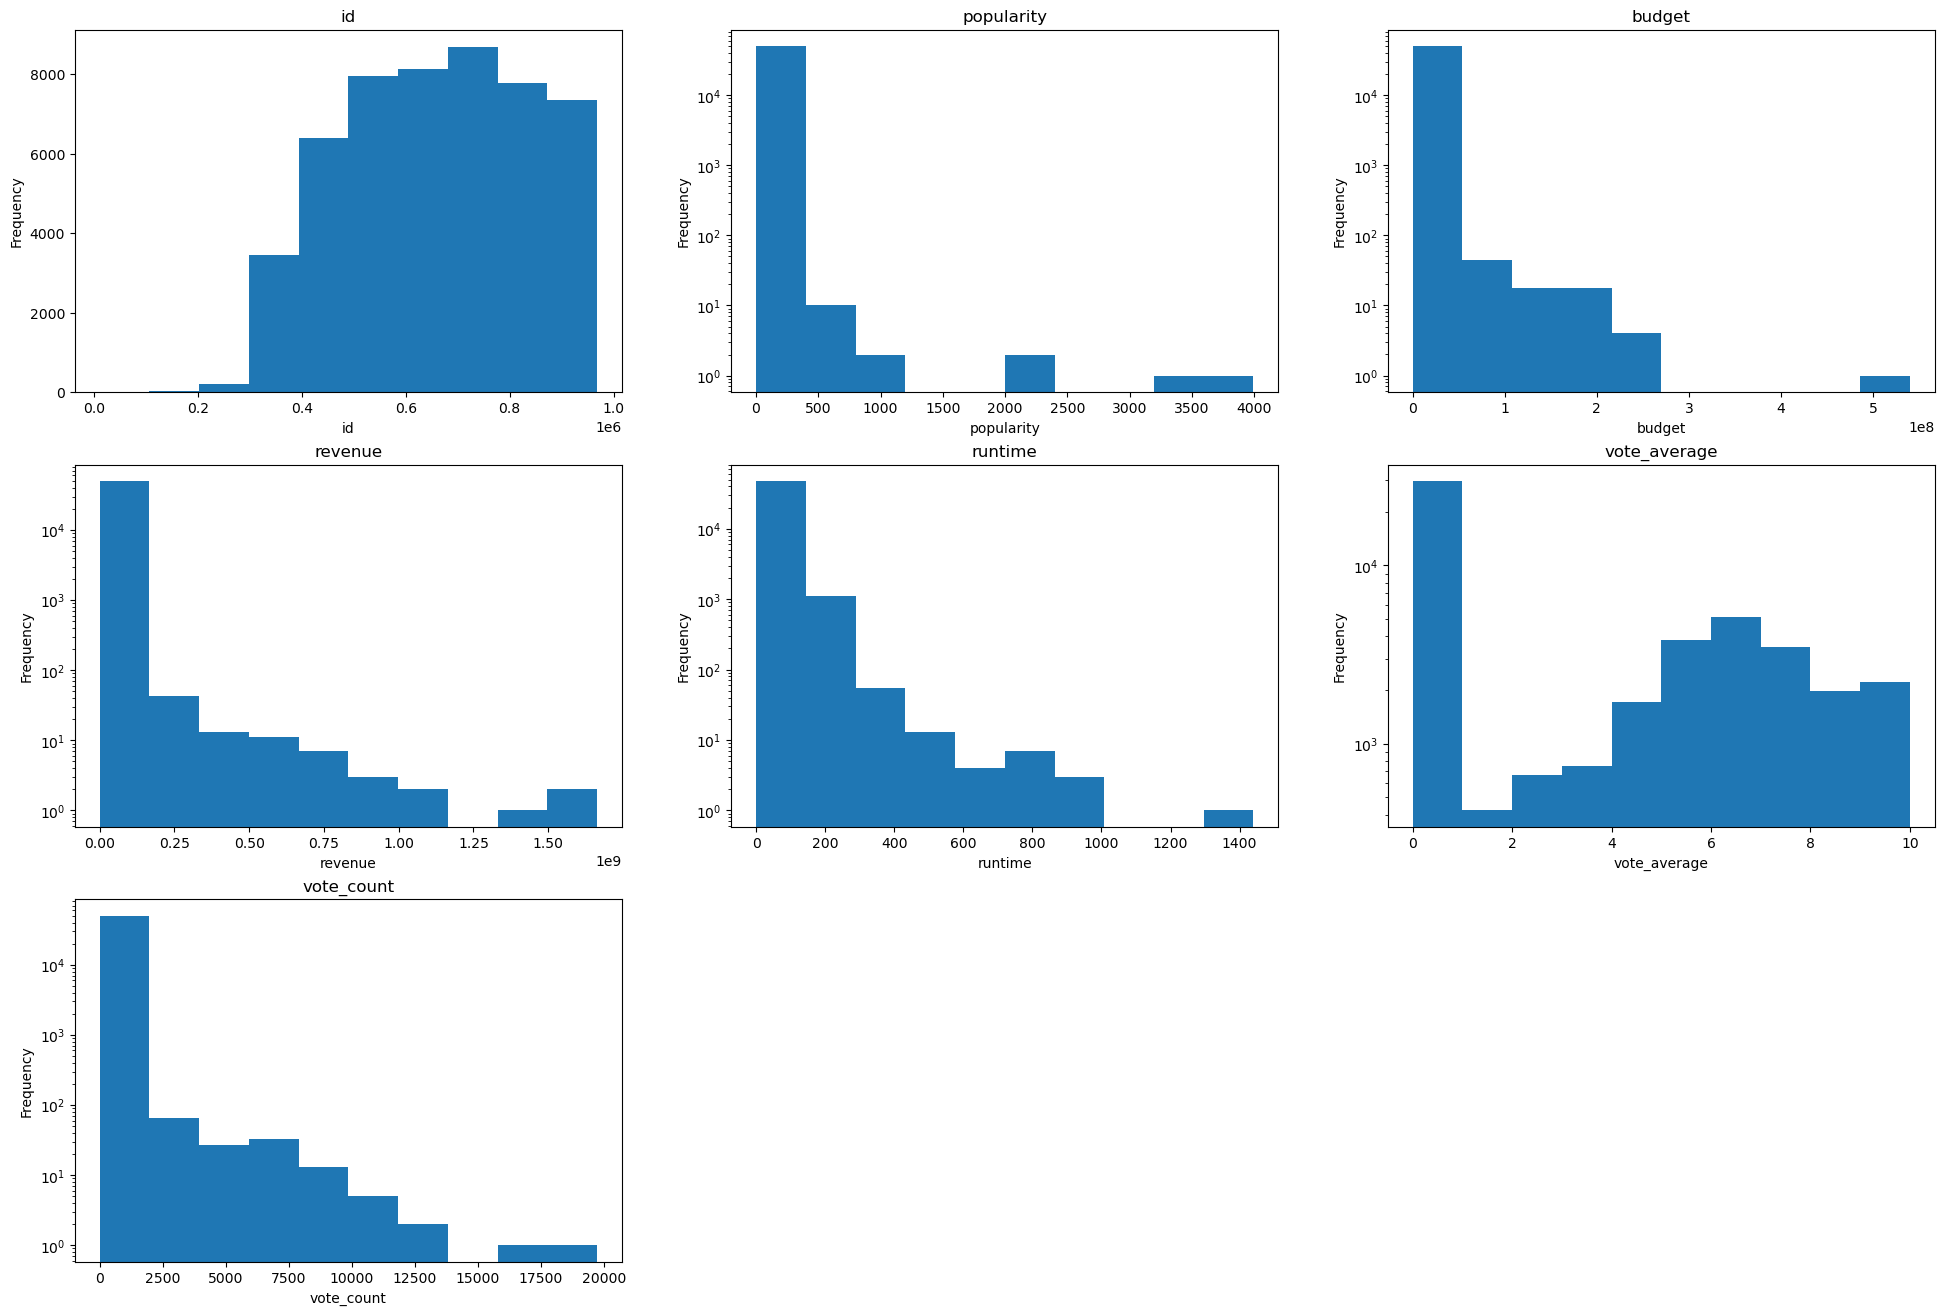

In [247]:
import matplotlib.pyplot as plt

numerical_columns = movies.select_dtypes(include='number').columns

num_plots = len(numerical_columns)
rows = 3 
cols = 3  

fig, axes = plt.subplots(rows, cols, figsize=(24, 16))

for i, column in enumerate(numerical_columns):
    row = i // cols  
    col = i % cols   
    movies[column].plot(kind='hist', ax=axes[row, col])
    axes[row, col].set_title(column)
    
    # Access and modify x-axis properties
    axes[row, col].set_xlabel(numerical_columns[i])
    # You can set ticks, limits, etc., for the x-axis similarly
    
    # Access and modify y-axis properties
    axes[row, col].set_ylabel('Frequency')
    # You can set ticks, limits, etc., for the y-axis similarly
    
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

axes[0,1].set_yscale('log')
axes[0,2].set_yscale('log')
axes[1,0].set_yscale('log')
axes[1,1].set_yscale('log')
axes[1,2].set_yscale('log')
axes[2,0].set_yscale('log')

plt.show()

In [248]:
# # Check for correlation between attributes using sns.pairplot.
# sns.pairplot(movies)  # isn't working for some reason, think on this later


### Curious note: Usually, one may presume that the greater the budget of the movie, the better revenue it may generate. So let's put this to the test:

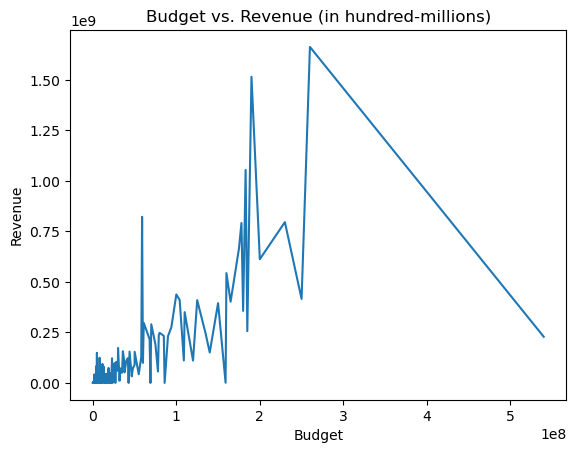

In [249]:
# Plot budget vs. revenue generated

budgetVsRevenue = sns.lineplot(x="budget", y="revenue", data=movies, errorbar=None)
# Set labels and title
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Budget vs. Revenue (in hundred-millions)')

plt.show()

Observation: As you can see, it is not necessarily the case that higher the budget, the more revenue is generated. For better visualization, we must clean this data to scale the x-axis (i.e., budget) to better see the correlation

Text(0, 0.5, 'revenue')

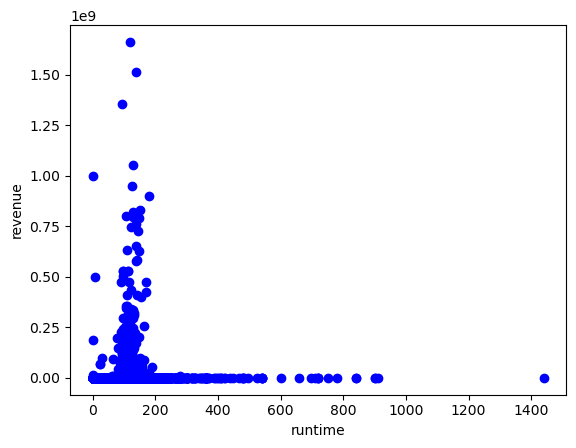

In [250]:
x_axis = movies["runtime"]
y_axis = movies["revenue"]
# Plot points
fig, pl = plt.subplots()
pl.scatter(x_axis, y_axis, color = 'b')
plt.xlabel("runtime")
plt.ylabel("revenue")

Observation: clearly, we need to get rid of the right most value as it is ruining the data plot. We need feature scaling after that. 
### Check the data cleaning part, we have removed the outliers by using a threshold for our movie runtime. We plot this graph again for better interpretations.

# 3 Preprocessing: Preparing data for Machine Learning tasks


## 3.1. - Data cleaning

Recall from above, that one runtime value is extraordinarily big. We will remove this outlier now.

In [251]:
# Assuming the threshold for high runtime is 150 minutes long
threshold_runtime = 150

# Create a boolean mask indicating which rows have runtime below or equal to the threshold
mask = movies['runtime'] <= threshold_runtime

# now, our dataframe contains only the rows with runtime below or equal to the threshold
movies = movies[mask]



Text(0, 0.5, 'revenue')

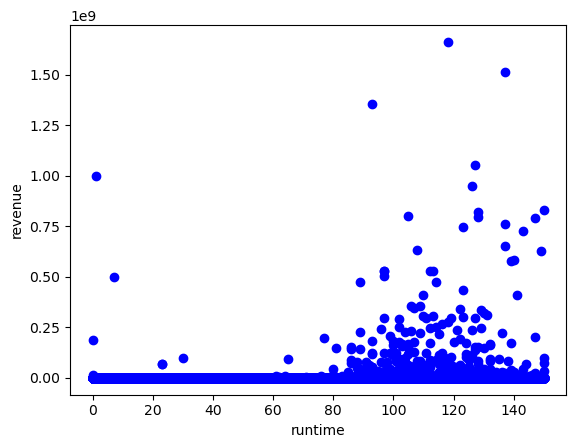

In [252]:
# We now show how our earlier plot becomes so much better:

x_axis = movies["runtime"]
y_axis = movies["revenue"]
# Plot points
fig, pl = plt.subplots()
pl.scatter(x_axis, y_axis, color = 'b')
plt.xlabel("runtime")
plt.ylabel("revenue")

3.1.1-  Checking for duplicates, and dropping them:

In [253]:
movies.duplicated().sum()

0

In [254]:
movies.drop_duplicates(inplace=True)

3.1.2 - Handle the missing values:

In [255]:
# Find the number of missing values in each column as a fraction out of total instances

movies.isna().sum()/len(movies)

id                      0.000000
title                   0.000021
genres                  0.226824
original_language       0.000000
overview                0.126421
popularity              0.000000
production_companies    0.536879
release_date            0.000000
budget                  0.000000
revenue                 0.000000
runtime                 0.000000
status                  0.000000
tagline                 0.832349
vote_average            0.000000
vote_count              0.000000
credits                 0.304922
keywords                0.699793
poster_path             0.129781
backdrop_path           0.574624
recommendations         0.941766
dtype: float64

Since, the 'recommendations' feature is nearly empty, its best that we drop it. Similarly, we'll drop 'tagline', 'backdrop_path', 'keywords', and 'production_companies'. We chose the threshold to be that if the feature is more than 50% empty, it will be entirely dropped.

In [256]:
movies.drop(labels=['recommendations'], axis=1, inplace=True)
movies.drop(labels=['tagline'], axis=1, inplace=True)
movies.drop(labels=['keywords'], axis=1, inplace=True)
movies.drop(labels=['production_companies'], axis=1, inplace=True)
movies.drop(labels=['genres'],axis=1,inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47927 entries, 703407 to 693196
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 47927 non-null  int64         
 1   title              47926 non-null  object        
 2   original_language  47927 non-null  object        
 3   overview           41868 non-null  object        
 4   popularity         47927 non-null  float64       
 5   release_date       47927 non-null  datetime64[ns]
 6   budget             47927 non-null  float64       
 7   revenue            47927 non-null  float64       
 8   runtime            47927 non-null  float64       
 9   status             47927 non-null  object        
 10  vote_average       47927 non-null  float64       
 11  vote_count         47927 non-null  float64       
 12  credits            33313 non-null  object        
 13  poster_path        41707 non-null  object        
 14  backd

Removing Unimport Fields

In [257]:
movies.drop(labels=['overview'], axis=1, inplace=True)
movies.drop(labels=['status'], axis=1, inplace=True)
movies.drop(labels=['credits'], axis=1, inplace=True)
movies.drop(labels=['title'], axis=1, inplace=True)
movies.drop(labels=['release_date'], axis=1, inplace=True)
movies.drop(labels=['poster_path'], axis=1, inplace=True)
movies.drop(labels=['backdrop_path'], axis=1, inplace=True)
movies.drop(labels=['original_language'], axis=1, inplace=True)
movies.drop(labels=['id'], axis=1, inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47927 entries, 703407 to 693196
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    47927 non-null  float64
 1   budget        47927 non-null  float64
 2   revenue       47927 non-null  float64
 3   runtime       47927 non-null  float64
 4   vote_average  47927 non-null  float64
 5   vote_count    47927 non-null  float64
dtypes: float64(6)
memory usage: 2.6 MB


#### For the remaining missing values, we will fill them with the mean if it is a numerical value and the most frequent if it is a categorical column

#### We will do this through creating a pipeline, that will also scale the features and perform encoding in the next step.

### 3.1.3 Creating a pipeline that will:

1. Fill in the missing numerical values with the mean using a SimpleImputer

2. Scale the numerical columns using StandardScaler. Do not scale the target

3. Fill in the missing categorical values with the most_frequent value using SimpleImputer

4. Encode the categorical columns using OneHotEncoder


In [258]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [259]:
# Create the cat and num columns
# Get a list of column names from the 'movies' DataFrame that are of numerical data types.
# Get a list of column names from the 'movies' DataFrame that are not of numerical data types.

num_cols = movies.select_dtypes(include='number').columns.to_list()
cat_cols = movies.select_dtypes(exclude='number').columns.to_list()


# Exclude the target from numerical columns
num_cols.remove("revenue")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),  OneHotEncoder(sparse_output=False))

# Use ColumnTransformer to set the estimators and transformations

preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [260]:
num_cols

['popularity', 'budget', 'runtime', 'vote_average', 'vote_count']

In [261]:
cat_cols

[]

In [262]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['popularity', 'budget', 'runtime',
                                  'vote_average', 'vote_count']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 [])])

In [263]:
# # Apply the preprocessing pipeline on the dataset                 # UNCOMMENT AND FIX THIS ERROR. THERE'S AN ERROR HERE.

movies_prepared = preprocessing.fit_transform(movies)

# # Scikit-learn strips the column headers, so just add them back on afterwards
feature_names=preprocessing.get_feature_names_out()
movies_prepared = pd.DataFrame(data=movies_prepared, columns=feature_names)

movies_prepared

,num__popularity,num__budget,num__runtime,num__vote_average,num__vote_count,remainder__revenue
0,-0.063437,-0.053904,-0.872573,1.777630,-0.076897,0.0
1,-0.063437,-0.053904,0.078101,-0.769658,-0.079892,0.0
2,-0.063437,-0.053904,-0.826199,-0.769658,-0.079892,0.0
3,-0.063437,-0.053904,-0.107397,-0.769658,-0.079892,0.0
4,-0.063437,-0.053904,0.217224,-0.769658,-0.079892,0.0
...,...,...,...,...,...,...
47922,-0.063437,-0.053904,-1.058071,-0.769658,-0.079892,0.0
47923,0.003567,-0.053904,0.356347,0.908555,-0.064915,0.0
47924,-0.063437,-0.053904,-0.803012,-0.769658,-0.079892,0.0
47925,-0.063437,-0.043088,-0.316081,2.227151,-0.076897,0.0


# 4 Training and evaluation of 3 Machine Learning Algorithms, findings, and result comparison

## 4.1 Training Split

In [264]:
from sklearn.model_selection import train_test_split
x = movies_prepared.drop(["remainder__revenue"], axis=1)
y = movies_prepared["remainder__revenue"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(38341, 5) (38341,) (9586, 5) (9586,)


## 4.1. - Training of 3 ML algorithms
- Algorithm 1: LinearRegression no regularization
- Algorithm 2:
- Algorithm 3: RandomForestRegressor

### Algorithm 1: Linear Regression no regularization

In [265]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

lr_model.fit(X_train,y_train)

LinearRegression()

In [266]:
lr_y_predict = lr_model.predict(X_test)

from sklearn.metrics import mean_squared_error as mse
lr_mse=mse(y_test, lr_y_predict)
lr_mse

295361821661853.75

### Algorthm 2: 

In [267]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [268]:
xgb_y_predict = xgb_model.predict(X_test)
xgb_mse = mse(y_test, xgb_y_predict)
xgb_mse

269605461729647.47

### Algorthm 3 

In [269]:
from sklearn.linear_model import Ridge
RidgeRegression = Ridge(alpha=1)
ridge_model = RidgeRegression.fit(X_train, y_train)

In [270]:
ridge_y_predict = ridge_model.predict(X_test)
ridge_mse = mse(y_test, ridge_y_predict)
ridge_mse

295355902620974.5

Polynomial Regression

In [271]:
# from sklearn.preprocessing import PolynomialFeatures
# poly_reg = PolynomialFeatures(degree=2)
# X_train_2 = poly_reg.fit_transform(X_train)
# X_test_2 = poly_reg.transform(X_test)
# poly_lr_model = LinearRegression(normalize=True)
# poly_lr_model.fit(X_train_2,y_train)

In [272]:
# poly_lr_y_predict = poly_reg.predict(X_test_2)
# poly_lr_mse = mse(y_test, poly_lr_y_predict)
# poly_lr_mse

RandomForestRegressor

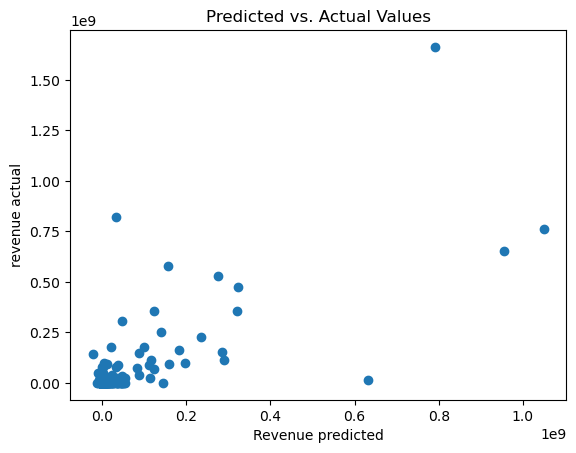

In [273]:
plt.scatter(xgb_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.title("Predicted vs. Actual Values")
plt.show()

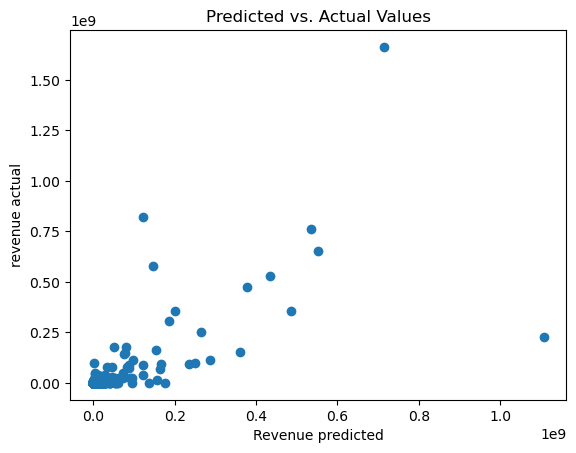

In [274]:
plt.scatter(ridge_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.title("Predicted vs. Actual Values")
plt.show()

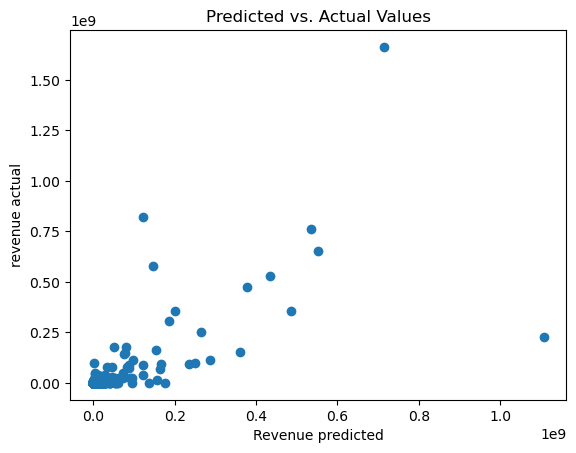

In [275]:
plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.title("Predicted vs. Actual Values")
plt.show()

## 4.2. - Analysis of findings



## 4.3. - Comparison of results

In [276]:
print(f'Linear Regression: {lr_mse}')
print(f'XGB Regression: {xgb_mse}')
print(f'Ridge Regression: {ridge_mse}')

Linear Regression: 295361821661853.75
XGB Regression: 269605461729647.47
Ridge Regression: 295355902620974.5


# 5 - Three Graphs for the best performance algorithm

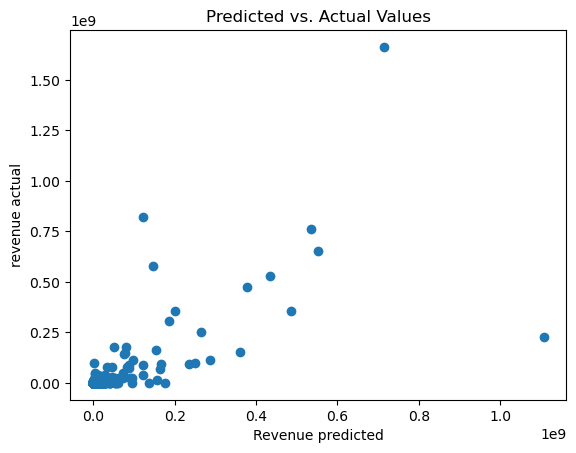

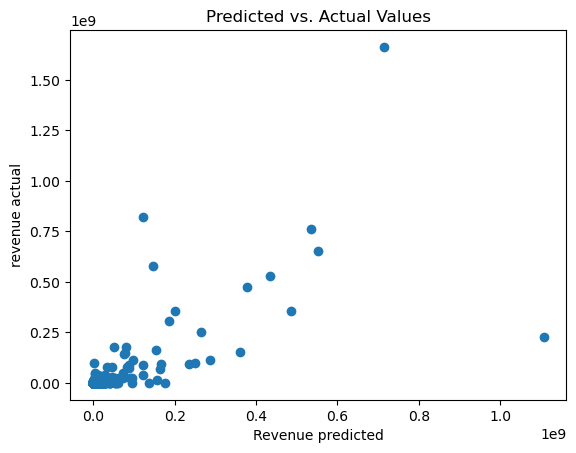

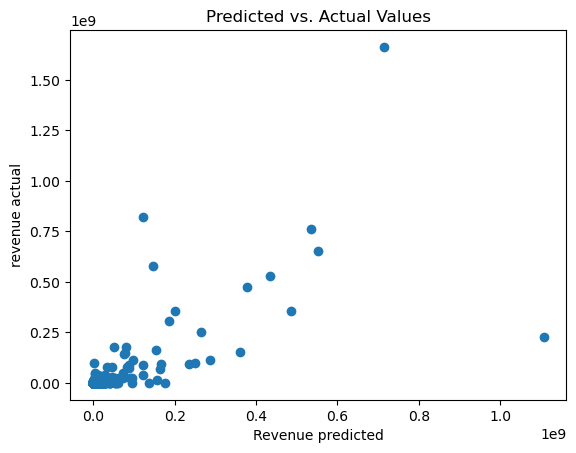

In [277]:
plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.title("Predicted vs. Actual Values")
plt.show()

plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.title("Predicted vs. Actual Values")
plt.show()

plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.title("Predicted vs. Actual Values")
plt.show()



# 6 Limitations of the project

The main limitations of the project are the amount of features 

# Appendix 1:

Empty unless we used someone else's code, then we cite it here

# Appendix 2: 

### Github repository link: https://github.com/Jayant1Varma/Movie-Box-Office-predictor.git 

**Original dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing**